In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import nltk
from nltk.tokenize import word_tokenize
from datasets import load_dataset

In [2]:
### Hyper Params
batch_size = 1
hidden_size = 120
input_size = 1
lr = 0.01
epochs = 2

In [3]:
raw_dataset = load_dataset("jaydenccc/AI_Storyteller_Dataset", split="train")['short_story']

In [4]:
nltk.download('punkt_tab')

text_corpus = ""
for item in raw_dataset:
    text_corpus += item.lower()

text_corpus = text_corpus.replace('.', '').replace(',','').replace('\n',' ').replace('\'', '').replace('\"', '').replace(':', '').replace('?', '').replace('!', '').replace(';', '').replace('-', '')
tokens = word_tokenize(text_corpus)
unique_words = set(tokens)
word_to_num = {word: idx for idx, word in enumerate(unique_words)}
num_to_word = {idx: word for idx, word in enumerate(unique_words)}

[nltk_data] Downloading package punkt_tab to /home/grant/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
output_size = len(word_to_num)

pad_tok_id = output_size
num_to_word[pad_tok_id] = '<pad>'
word_to_num['<pad>'] = pad_tok_id

num_to_word[output_size+1] = ''
word_to_num[''] = output_size+1

output_size = len(word_to_num)

In [6]:
class StoryDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [7]:
pads = ['<pad>' for i in range(9)]
corpus = text_corpus.split(' ')

train_dataset = StoryDataset(corpus[:25000])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

test_dataset = StoryDataset(corpus[25000:])
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [8]:
for i, batch in enumerate(train_dataloader):
    # Give model i word, output should be id of next word. So loss will be item+1
    if i > 10:
        break
    print(batch)

['detective']
['emily']
['had']
['always']
['dreamt']
['of']
['getting']
['an']
['exciting']
['case']
['to']


In [9]:
class RNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Init hidden state (batch size * hidden size)
        batch_size = x.size(0)
        hidden = torch.zeros(1, batch_size, self.hidden_size) # 

        # Forward through net
        out, hidden = self.rnn(x, hidden)

        # Only use last hidden state for output
        out = self.fc(out[:, -1, :])
        return out

In [10]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_size, 240),
            nn.ReLU(),
            nn.Linear(240, 480),
            nn.ReLU(),
            nn.Linear(480, output_size)
        )
    def forward(self, x):
        return self.fc(x)
        # return torch.argmax(x, dim=0)

In [11]:
net = Net()
crit = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters(), lr=lr)

In [12]:
out = net(torch.tensor([word_to_num['upon']], dtype=torch.float32))

In [13]:
# net.train()
# for epoch in range(epochs):
#     for i, item in enumerate(train_dataset):
#         if i < len(train_dataset)-1:
#             opt.zero_grad()
#             output = net(torch.tensor([word_to_num[item]], dtype=torch.float32))
#             label = torch.tensor(word_to_num[train_dataset[i+1]], dtype=torch.float32)

#             print(output, label)
            
#             loss = crit(output, label)
#             loss.backward()
#             opt.step()
#             print(loss.item())
avg_loss = 0
net.train()
for epoch in range(epochs):
    for i, item in enumerate(train_dataset):
        if i < len(train_dataset) - 1:
            opt.zero_grad()
            
            # Prepare input and target
            input_tensor = torch.tensor([[word_to_num[item]]], dtype=torch.float32)
            target_tensor = torch.tensor([word_to_num[train_dataset[i+1]]], dtype=torch.long)
            
            # Forward pass
            output = net(input_tensor)
            
            # Compute loss
            loss = crit(output, target_tensor)
            loss.backward()
            opt.step()
            avg_loss += loss.item()

        if i % 100 == 0:
            print(f'Loss: {avg_loss/100}, Step: {i}/{len(train_dataset)}')
            avg_loss = 0

Loss: 9.653342895507812, Step: 0/25000
Loss: 555.5425284004211, Step: 100/25000
Loss: 7.906805210113525, Step: 200/25000
Loss: 7.366302399635315, Step: 300/25000
Loss: 7.569762182235718, Step: 400/25000
Loss: 7.373135266304016, Step: 500/25000
Loss: 7.351459641456604, Step: 600/25000
Loss: 7.286879057884216, Step: 700/25000
Loss: 7.372102749347687, Step: 800/25000
Loss: 7.443263423442841, Step: 900/25000
Loss: 7.0087655687332155, Step: 1000/25000
Loss: 7.52756477355957, Step: 1100/25000
Loss: 13.511583476066589, Step: 1200/25000
Loss: 7.370755836963654, Step: 1300/25000
Loss: 7.559735224246979, Step: 1400/25000
Loss: 7.590172894001007, Step: 1500/25000
Loss: 7.11024962425232, Step: 1600/25000
Loss: 7.334508609771729, Step: 1700/25000
Loss: 7.546393492221832, Step: 1800/25000
Loss: 7.436902322769165, Step: 1900/25000
Loss: 7.579100074768067, Step: 2000/25000
Loss: 6.888727729320526, Step: 2100/25000
Loss: 7.247100560665131, Step: 2200/25000
Loss: 8.19599015712738, Step: 2300/25000
Loss:

In [14]:
PATH = './next_word_2.pth'
torch.save(net.state_dict(), PATH)

Word: the


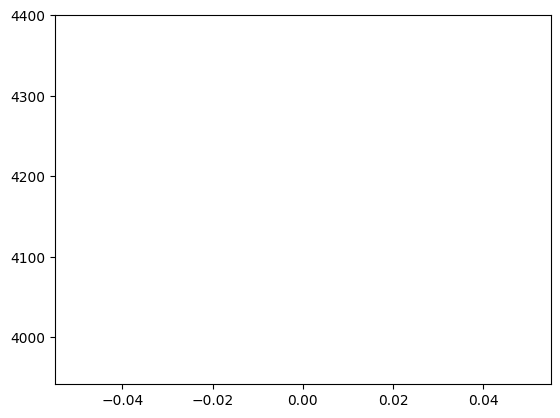

In [20]:
import matplotlib.pyplot as plt

input_tensor = torch.tensor([[word_to_num["the"]]], dtype=torch.float32)

# Forward pass
output = torch.argmax(net(input_tensor))
print(f'Word: {num_to_word[output.item()]}')

plot = output.detach().numpy()
plt.plot(plot)
plt.show()
# plt.figure(figsize=(10, 6))
# plt.bar(range(len(fc1_logits[0])), fc1_logits[0], color='blue', alpha=0.7)
# plt.title("Logits from fc1 Layer")
# plt.xlabel("Neuron Index")
# plt.ylabel("Logit Value")
# plt.show()